# Random Forest Grid Search - Part 1
This script takes in the 10 folds of data and runs a grid search over a set of hyperparameters.

The grid search takes a long time, but it will run in the background on the Google cloud! I used the Google Earth Engine API, but you could also convert to a geopandas dataframe and use a machine learning library like [scikit learn](https://scikit-learn.org/stable/). I wanted to optimize the Google Earth Engine parameters so I could build a Google Earth Engine App with the results.

In [1]:
# Accesses Earth Engine API
import ee
ee.Authenticate()
ee.Initialize(project='ee-aspenjkmorgan')
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

### Import 10 folds of data. I split this up in advance to keep the folds consistent across all models.

In [2]:
# import the 10-folds of training and validation data
# switch to one based indexing
f0 = ee.FeatureCollection('users/aspenjkmorgan/k_folds/f0_v2')
f1 = ee.FeatureCollection('users/aspenjkmorgan/k_folds/f1_v2')
f2 = ee.FeatureCollection('users/aspenjkmorgan/k_folds/f2_v2')
f3 = ee.FeatureCollection('users/aspenjkmorgan/k_folds/f3_v2')
f4 = ee.FeatureCollection('users/aspenjkmorgan/k_folds/f4_v2')
f5 = ee.FeatureCollection('users/aspenjkmorgan/k_folds/f5_v2')
f6 = ee.FeatureCollection('users/aspenjkmorgan/k_folds/f6_v2')
f7 = ee.FeatureCollection('users/aspenjkmorgan/k_folds/f7_v2')
f8 = ee.FeatureCollection('users/aspenjkmorgan/k_folds/f8_v2')
f9 = ee.FeatureCollection('users/aspenjkmorgan/k_folds/f9_v2')

In [3]:
# create 10 training sets (train0 contains all folds except f0)
train0 = ee.FeatureCollection([f1, f2, f3, f4, f5, f6, f7, f8, f9]).flatten()
train1 = ee.FeatureCollection([f0, f2, f3, f4, f5, f6, f7, f8, f9]).flatten()
train2 = ee.FeatureCollection([f1, f0, f3, f4, f5, f6, f7, f8, f9]).flatten()
train3 = ee.FeatureCollection([f1, f2, f0, f4, f5, f6, f7, f8, f9]).flatten()
train4 = ee.FeatureCollection([f1, f2, f3, f0, f5, f6, f7, f8, f9]).flatten()
train5 = ee.FeatureCollection([f1, f2, f3, f4, f0, f6, f7, f8, f9]).flatten()
train6 = ee.FeatureCollection([f1, f2, f3, f4, f5, f0, f7, f8, f9]).flatten()
train7 = ee.FeatureCollection([f1, f2, f3, f4, f5, f6, f0, f8, f9]).flatten()
train8 = ee.FeatureCollection([f1, f2, f3, f4, f5, f6, f7, f0, f9]).flatten()
train9 = ee.FeatureCollection([f1, f2, f3, f4, f5, f6, f7, f8, f0]).flatten()

### Helper functions

In [ ]:
# Compute the difference between computed pm25 and actual
def difference(feature):
  diff = ee.Number(feature.get('pm_cal')) \
    .subtract(ee.Number(feature.get('pm25')))
  # Return the feature with the squared difference set to the 'diff' property.
  return feature.set('sq_diff', diff.pow(2))

def runModel(feature):
  var = feature.get('var')
  leaf = feature.get('leaf')
  bag = feature.get('bag')
  rf_model = ee.Classifier.smileRandomForest(**{
        'numberOfTrees': 100, # total trees used
        'variablesPerSplit': var, # if unspecified, using 2 or 3
        'minLeafPopulation': leaf, # only trees trained with > this amt of data points
        'bagFraction': bag, # fraction of data sampled for each tree
        'maxNodes': None, # max nodes of tree
        'seed': 0}) \
        .setOutputMode('REGRESSION')\
        .train(**{
          'features': training,
          'classProperty': 'pm25',
          'inputProperties': ['PRES', 'aod', 'RH', 'PBLH', 'DPT', 'WIND', 'WDIR', 'TMP']
      })

  # apply model to validation data and apply to training data
  val_data_applied = validation.classify(rf_model, 'pm_cal')
  train_data_applied = training.classify(rf_model, 'pm_cal')

  # RMSE for validation data
  val_diff = val_data_applied.map(difference)
  val_rmse = ee.Number(val_diff.reduceColumns(ee.Reducer.mean(), ['sq_diff']) \
    .get('mean')).sqrt();

  # RMSE for training data
  train_dif = train_data_applied.map(difference)
  train_rmse = ee.Number(train_dif.reduceColumns(ee.Reducer.mean(), ['sq_diff']) \
    .get('mean')).sqrt();

  return ee.Feature(None, {'var': var, 'leaf': leaf, 'bag': bag, 'train_rmse': train_rmse,
                                      'val_rmse': val_rmse})

### Create an ee.FeatureCollection with hyperparamter options. This is necessary for applying a function to each feature in a collection.

In [ ]:
# feature collection of all the hyperparameter options
options = []
var_list = range(1, 9)
leaf_list = range(1, 11)
bag_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
for v in var_list:
  for l in leaf_list:
    for b in bag_list:
      feature = ee.Feature(None, {'var': v, 'leaf': l, 'bag': b})
      options.append(feature)
options_col = ee.FeatureCollection(options)

### Run the grid search across each fold of data

In [ ]:
# keys are training and items are testing
folds = {
    train0: f0,
    train1: f1,
    train2: f2,
    train3: f3,
    train4: f4,
    train5: f5,
    train6: f6,
    train7: f7,
    train8: f8,
    train9: f9
}

In [ ]:
all_results = []
count = 0 # keep track of which fold it is
for training in folds:

  # get validation fold
  validation = folds[training]

  # run a grid search on hyperparameters
  fold_result = ee.FeatureCollection(options_col.map(runModel))
  collection = fold_result.set('fold', count)
  all_results.append(collection)

  count += 1

# combine table of all results
table = ee.FeatureCollection(all_results).flatten()

### Export to Google Drive as a csv

In [ ]:
ee.batch.Export.table.toDrive(**{
    'collection': table,
    'description': 'k_fold_results',
    'folder': 'Random_Forest_Iterations',
    'fileNamePrefix': 'k_fold_results_23-12-22__70-30'}).start()

# Grid Search Part 2: Best Parameters
Takes in the csv containing all grid search data from part 1 and determines:
* the best parameters
* the best split in data (fold)

### Open results from part 1

In [ ]:
# open results in a dataframe
import pandas as pd
kf_results = pd.read_csv('/content/drive/MyDrive/INBRE/Random_Forest_Iterations/k_fold_results_23-12-22__70-30.csv')
kf_results['fold'] = kf_results['system:index'].apply(lambda x: x.split('_')[0])
kf_results.drop(axis=1, columns=['system:index', '.geo'], inplace=True)
kf_results.head(3)

,bag,leaf,train_rmse,val_rmse,var,fold
0,0.1,1,10.585391,10.127737,1,0
1,0.2,1,9.689844,9.873366,1,0
2,0.3,1,8.825524,9.692761,1,0


### Determine best hyperparameters and best split in data

In [ ]:
# get best CV hyperparameters
# for each combination, get test CV
vars = []
leafs = []
bags = []
cvs = []
for v in var_list:
  for l in leaf_list:
    for b in bag_list:
      vars.append(v)
      leafs.append(l)
      bags.append(b)
      buf_table = kf_results.loc[(kf_results['leaf'] == l) & (kf_results['var'] == v) & (kf_results['bag'] == b), :]
      cvs.append(buf_table.val_rmse.mean())

cv_results = pd.DataFrame({'var': vars, 'leaf': leafs, 'bag': bags, 'Test_CV': cvs})
best_values = cv_results.loc[cv_results.Test_CV == cv_results.Test_CV.min(), :]
best_values

,var,leaf,bag,Test_CV
184,3,1,0.5,9.649113
193,3,2,0.5,9.649113


I will use the second option since it may (slightly) reduce overfitting.

### Iterate through the folds again and run the random forest model using the best parameters

In [ ]:
# empty list to hold results
buf_list = []
counter = 0
for training in folds:

  # get validation fold
  validation = folds[training]

  # run random forest with optimal hyperparameters
  rf_model = ee.Classifier.smileRandomForest(**{
        'numberOfTrees': 100,
        'variablesPerSplit': int(best_values.iloc[1, 0]),
        'minLeafPopulation': int(best_values.iloc[1, 1]),
        'bagFraction': float(best_values.iloc[1, 2]),
        'maxNodes': None,
        'seed': 0}) \
        .setOutputMode('REGRESSION')\
        .train(**{
          'features': training,
          'classProperty': 'pm25',
          'inputProperties': ['PRES', 'aod', 'RH', 'PBLH', 'DPT', 'WIND', 'WDIR', 'TMP']
      })

  # apply model to validation data only
  val_data_applied = validation.classify(rf_model, 'pm_cal')
  val_data_applied = val_data_applied.set('fold', counter)
  buf_list.append(val_data_applied)

  # increment counter
  counter += 1

# combine feature collections of results and flatten
val_table = ee.FeatureCollection(buf_list).flatten()

### Export a CSV for calculating other CV metrics using the best hyperparameters.

In [ ]:
# export table of iterations to drive
ee.batch.Export.table.toDrive(**{
    'collection': val_table,
    'description': 'CV_for_coef_of_determination_23-12-22__70-30',
    'folder': 'Random_Forest_Iterations',
    'fileNamePrefix': 'CV_for_coef_of_determination_23-12-22__70-30'}).start()

# Grid Search Part 3: CV Coefficient of Determination

### Import the csv from part 2

In [ ]:
table = pd.read_csv('/content/drive/MyDrive/INBRE/Random_Forest_Iterations/CV_for_coef_of_determination_23-12-22__70-30.csv')
table['fold'] = table['system:index'].apply(lambda x: x.split('_')[0])
table.drop(axis=1, columns=['system:index', 'random'], inplace=True)
table['fold'] = table['fold'].astype('int')
table.head(3)

,DPT,PBLH,PRES,RH,TMP,WDIR,WIND,aod,pm25,pm_cal,station,system:time_start,.geo,fold
0,-0.549994,2201.431641,91381.5,18.980433,24.629984,275.050018,0.655,0.0965,8.476500,8.928406,Flathead Valley,1337025600000,"{""type"":""Point"",""coordinates"":[-114.189259,48....",0
1,10.300013,2096.877441,91049.0,33.478488,27.829981,322.049988,1.265,0.0785,6.724500,8.372209,Flathead Valley,1342987200000,"{""type"":""Point"",""coordinates"":[-114.189259,48....",0
2,8.600000,1772.299927,91402.5,39.389531,23.169992,157.300003,1.570,0.0730,5.236125,6.654526,Flathead Valley,1343844000000,"{""type"":""Point"",""coordinates"":[-114.189259,48....",0


### Calculate the cross validated coefficient of determination and RMSE

In [ ]:
# get R2 for each fold
def getR2(subtable):
  actual = subtable['pm25']
  pred = subtable['pm_cal']
  mean_actual = actual.mean()
  rss = sum((actual - pred)**2)
  tss = sum((actual - mean_actual)**2)
  return 1 - (rss/tss)

def getRMSE(subtable):
  actual = subtable['pm25']
  pred = subtable['pm_cal']
  sq_diff = sum((actual - pred)**2)
  return np.sqrt(sq_diff/len(subtable))

r2_values = []
rmse_values = []
for i in range(10):
  r2_values.append(getR2(table.loc[table.fold == i, :]))
  rmse_values.append(getRMSE(table.loc[table.fold == i, :]))

r2_vals = pd.DataFrame(r2_values, columns=['r2'])
cv_r2 = r2_vals['r2'].mean()
print('Cross validated r2: ' + str(cv_r2))

rmse_vals = pd.DataFrame(rmse_values, columns=['rmse'])
cv_rmse = rmse_vals['rmse'].mean()
print('Cross validated RMSE: ' + str(cv_rmse))

Cross validated r2: 0.5743280426505428
Cross validated RMSE: 9.649112772469334


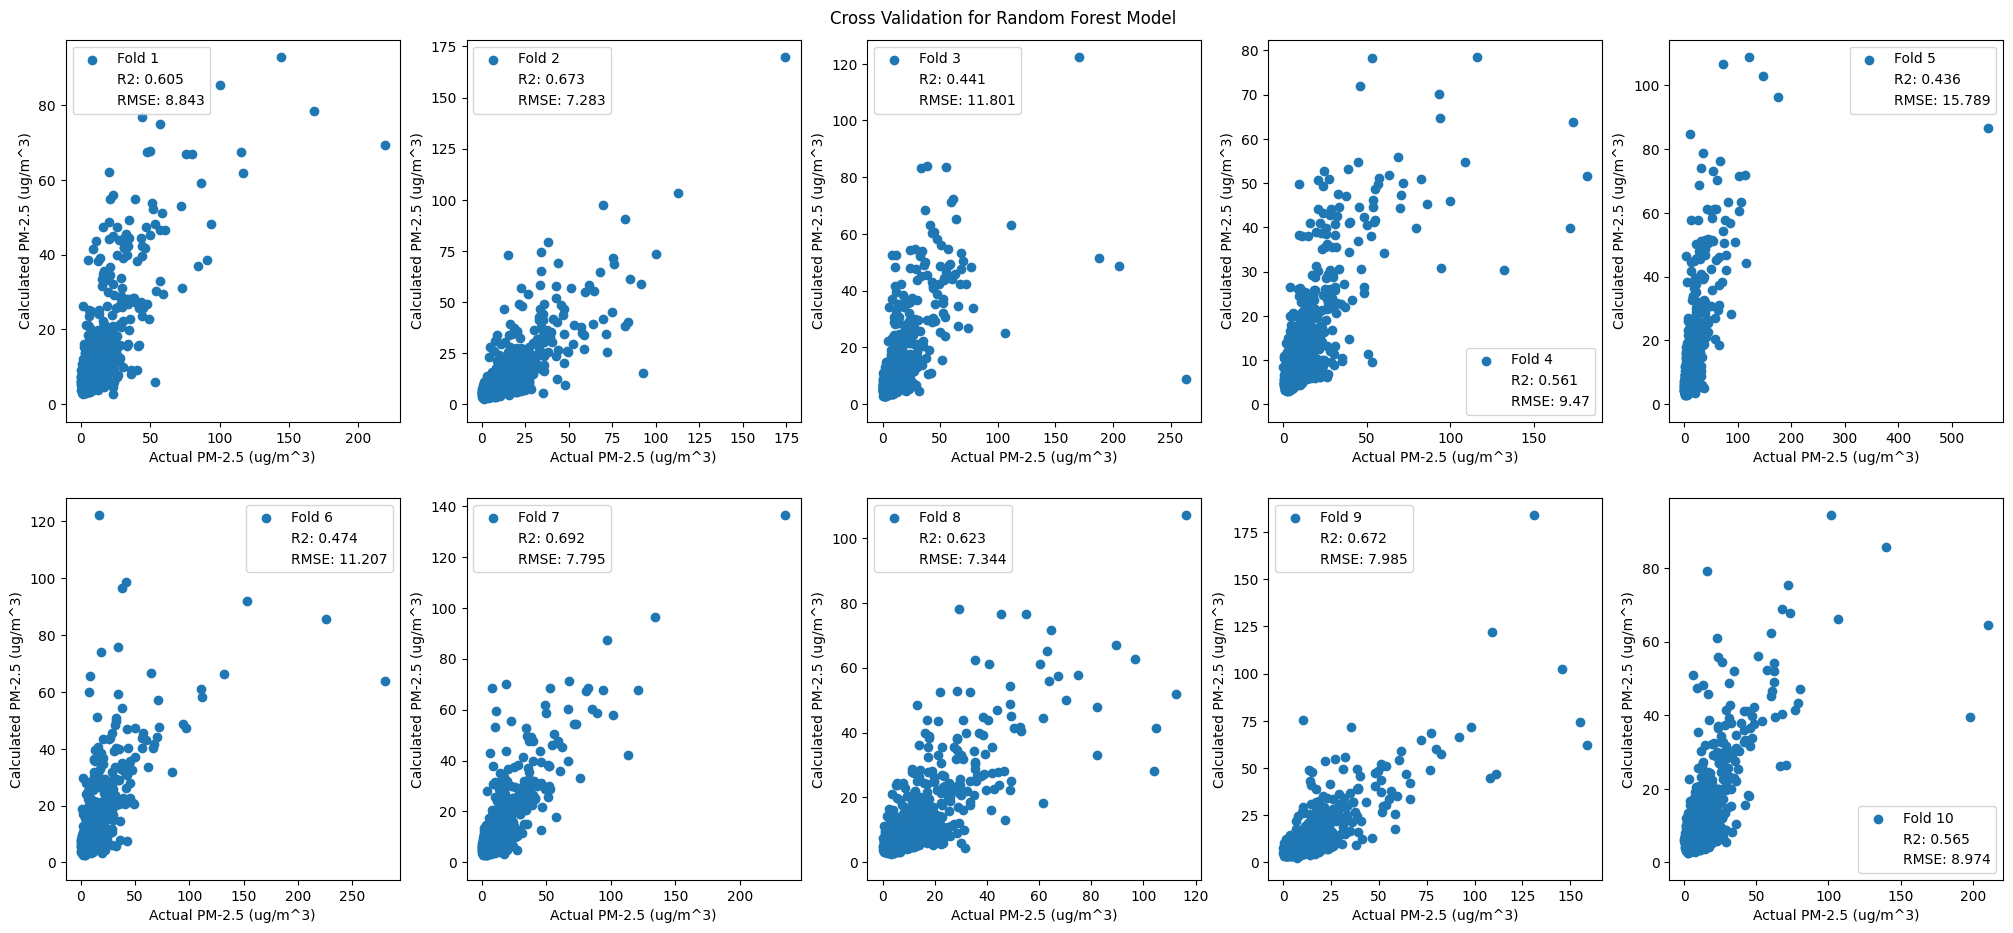

In [ ]:
# plot each folds pm25 vs pm_cal on one plot
fig, ax = plt.subplots(2, 5, figsize=(25, 10))
fig.suptitle('Cross Validation for Random Forest Model')
fig.subplots_adjust(top=0.95)
for i in range(0, 10):
  subtable = table.loc[table.fold == i, ['pm25', 'pm_cal']]
  ax[i//5][i%5].scatter(subtable.pm25, subtable.pm_cal, label='Fold ' + str(i+1))
  ax[i//5][i%5].plot(0, 0, alpha=0, label='R2: ' + str(round(r2_vals.iloc[i, 0], 3)))
  ax[i//5][i%5].plot(0, 0, alpha=0, label='RMSE: ' + str(round(rmse_vals.iloc[i, 0], 3)))
  ax[i//5][i%5].set_xlabel('Actual PM-2.5 (ug/m^3)')
  ax[i//5][i%5].set_ylabel('Calculated PM-2.5 (ug/m^3)')
  ax[i//5][i%5].legend()

# save residuals plots
plt.savefig("cv_random_forest.pdf", bbox_inches='tight')

In [4]:
# export training data with lowest RMSE (corresponds to fold 2 in chart above)
ee.batch.Export.table.toAsset(train1, 'train1', 'users/aspenjkmorgan/k_folds/train1_v2').start()